<a href="https://colab.research.google.com/github/andreaco/SpokenDigitClassification/blob/master/SpokenDigitClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spoken Digit Classification

## Imports and dataset download

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio

In [0]:
! git -q clone https://github.com/Jakobovski/free-spoken-digit-dataset
#! pip install -r free-spoken-digit-dataset/pip_requirements.txt # probably not needed

## Dataset import 

The informations about the audio track are retrieved from the name using the following regexp
```python
'([0-9])+_([a-z]+)_([0-9]+).wav'
```
With this we can retrieve from the 3 groups
```python
# Digit Label
regexp.search(filename).group(1)
# Spearker Name (maybe we'll need this later while analyzing the data?)
regexp.search(filename).group(2)
# File Index
regexp.search(filename).group(3)
```


In [0]:
# recordings directory
directory = 'free-spoken-digit-dataset/recordings/'
# regexp matching {digitLabel}_{speakerName}_{index}.wav
regexp = re.compile('([0-9])+_([a-z]+)_([0-9]+).wav') 

labels = []
audios = []
indexes = []
sizes = []

# setup progress bar
pbar = tqdm(desc='Loading audio samples')
pbar.reset(total=len(os.listdir(directory))) 

for f in os.listdir(directory):
  if f.endswith(".wav"):
    labels.append(regexp.search(f).group(1))
    indexes.append(int(regexp.search(f).group(3)))
    x, sr = librosa.load(directory+f, sr=None)
    sizes.append(x.size)
    audios.append(x)
    pbar.update() # updates progress bar
pbar.refresh();

# python lists to np.ndarray
Y = np.asarray(labels)
X = np.asarray(audios)
I = np.asarray(indexes)

Here we're doing a train-test split using the conditions stated in the github repository

In [0]:
# python lists to np.ndarray
Y = np.asarray(labels)
X = np.asarray(audios)
I = np.asarray(indexes)

# condition stated in the git repository for the test/train subdivision
is_in_test  = I <= 4
is_in_train = I >  4

Y_test, Y_train = Y[is_in_test], Y[is_in_train]

X_test, X_train = X[is_in_test], X[is_in_train]

## Dataset Analysis

Audio length: max = 2.28275 s, min = 0.1435 s


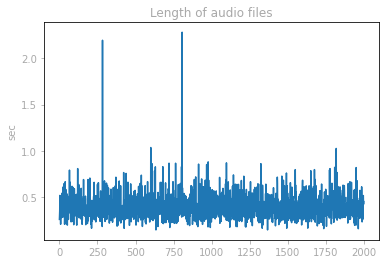

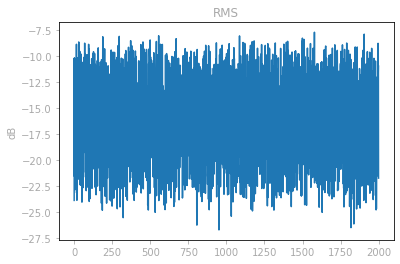

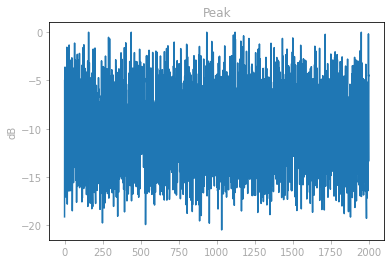

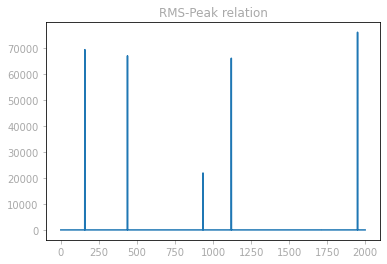

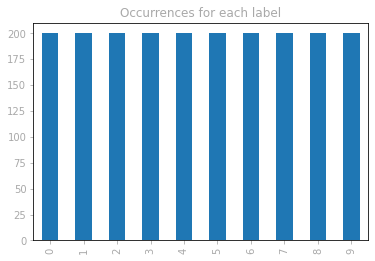

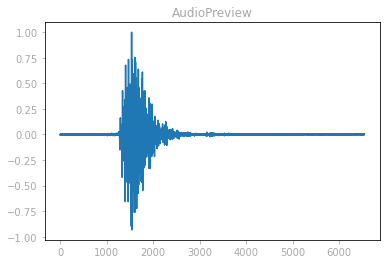

In [0]:
db_ref = 1.0
audioprev = np.zeros(8000)


# Sizes plot
plt.figure()
plt.title("Length of audio files")
plt.ylabel("sec")
plt.plot(np.array(sizes)/8000);
print("Audio length: max = {} s, min = {} s".format(np.max(sizes)/8000, np.min(sizes)/8000))

# RMS Plot (remember to check rms after zero-pad)
rms = []
peak = []
for x in audios:
  rms.append(np.sqrt(np.mean(np.square(x))))
  peak.append(np.max(x))

rms = np.array(rms)
db_rms = 10*np.log10(rms/db_ref)
peak = np.array(peak)
db_peak = 10*np.log10(peak/db_ref)
plt.figure()
plt.title("RMS")
plt.ylabel("dB")
plt.plot(db_rms);

plt.figure()
plt.title("Peak")
plt.ylabel("dB")
plt.plot(db_peak);

plt.figure()
plt.title("RMS-Peak relation")
plt.plot(db_rms/db_peak)

# Histogram of occurrences
from collections import Counter
count = Counter(labels)
df = pd.DataFrame.from_dict(count, orient='index')
df.sort_index().plot(kind='bar', title='Occurrences for each label', legend=False);



audioprev = audios[np.argmax(db_rms/db_peak)]
plt.figure()
plt.title("AudioPreview")
plt.plot(audioprev)

Audio(audioprev, rate=8000)

## Style

In [0]:
import matplotlib as mpl
COLOR = 'darkgrey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR